# Genome Wide Association Study with MRI data

In [1]:
from scipy.stats.mstats import winsorize
from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import math
import sys
import os

## Introduction

During this step we will compute the SNP-PD associations, using MRI imaging information to improve the phenotypic associations.

This step is part of the Individual View phase, which focuses on finding candidate SNP biomarkers by integrating genetic and neuroimaging data. We search for SNP-disease associations accounting for the phenotypic information carried by each imaging measure separately, and by integrating the single results obtained, in order to retrieve comprehensive potential SNP biomarkers for each imaging type considered, as we did with DaTSCAN data. 

To combine the results obtained accounting for each MRI feature separately, we use TATES (Van der Sluis *et al*., 2013), which combines the *P*-values in a single-trait-based statistical significance, by correcting for correlation among the imaging features, and evaluating if at least one of the analyzed traits could be associated with a SNP.

In [2]:
genotyping_path = "../../data/genotyping/"
imaging_path = "../../data/imaging/"
patdocs_path = "../../data/patient_docs/"
mri_path = os.path.join(imaging_path, "MRI")

## GWAS with MRI features

### Exploring MRI data

During previous steps we selected the MRI imaging measures related to the subjects considered in our study and retrieved during their baseline visit.

In [3]:
mri = pd.read_csv(
    os.path.join(mri_path, "mriFeatures_eu_woswedd.csv")
)
mri.head(n=10)

PATNO          eTIV  lh_caudalanteriorcingulate_volume  \
0   3000  1.569770e+06                             2565.0   
1   3001  1.715151e+06                             1848.0   
2   3002  1.356459e+06                             1154.0   
3   3004  1.617682e+06                             2092.0   
4   3006  1.643901e+06                             1589.0   
5   3008  1.281808e+06                              908.0   
6   3011  1.722969e+06                             2452.0   
7   3012  1.745686e+06                             2805.0   
8   3016  1.690582e+06                             1500.0   
9   3018  1.553345e+06                             1658.0   

   lh_caudalmiddlefrontal_volume  lh_cuneus_volume  lh_entorhinal_volume  \
0                         5700.0            3970.0                1928.0   
1                         6032.0            3058.0                2674.0   
2                         5947.0            2745.0                2023.0   
3                         5010.0            2794.0                2410.0   
4                         5893.0            3013.0                2465.0   
5                         3404.0            2507.0                1774.0   
6                         7466.0            3012.0                2170.0   
7                         7717.0            3027.0                2531.0   
8                         7638.0            3387.0                3076.0   
9                         5570.0            2644.0                2373.0   

   lh_fusiform_volume  lh_inferiorparietal_volume  lh_inferiortemporal_volume  \
0              9789.0                     12025.0                      9914.0   
1              9113.0                     13595.0                     12072.0   
2             10042.0                     11473.0                      9592.0   
3             10182.0                     10901.0                     12422.0   
4             10977.0                     14361.0                     12061.0   
5              9779.0                     10165.0                      7686.0   
6             10222.0                     14500.0                     14181.0   
7             11182.0                     14100.0                     12951.0   
8             13037.0                     12706.0                     14916.0   
9              9315.0                     11720.0                     11123.0   

   lh_isthmuscingulate_volume  ...  SupraTentorialVol  \
0                      2204.0  ...       9.996803e+05   
1                      2096.0  ...       1.138365e+06   
2                      2338.0  ...       9.026203e+05   
3                      2341.0  ...       1.074093e+06   
4                      2982.0  ...       1.120597e+06   
5                      2077.0  ...       7.901650e+05   
6                      3212.0  ...       1.110978e+06   
7                      3811.0  ...       1.171237e+06   
8                      2781.0  ...       1.103874e+06   
9                      3358.0  ...       9.144420e+05   

   SupraTentorialVolNotVent  SupraTentorialVolNotVentVox  TD_score  \
0              9.777723e+05                     973296.0  0.000000   
1              1.094811e+06                    1092459.0  0.272727   
2              8.838913e+05                     881444.0  0.181818   
3              1.056334e+06                    1053446.0  0.000000   
4              1.091968e+06                    1089715.0  0.090909   
5              7.530110e+05                     749890.0  0.000000   
6              1.092647e+06                    1089056.0  0.000000   
7              1.141054e+06                    1137124.0  1.000000   
8              1.075387e+06                    1071616.0  0.000000   
9              8.786950e+05                     876608.0  0.454545   

   PIGD_score  TD_PIGD_ratio  TD_PIGD_class     INFODT_   INFODT_bl  \
0         0.0            NaN  Indeterminate  2011-02-01  2011-02-01   
1         0.0            NaN             TD  2011-03-01      

### Constructing phenotype and covariate files

Before finding statistically significant SNP-phenotype associations with PLINK we need to define the phenotype and covariate file, as done with DaTSCAN data.

We remind that the phenotype file contains the phenotypic information to add to the model computed by PLINK (in our study, subjects enrolment category and imaging measures), and that the covariate file contains all the confounders used to adjust the linear model (in our study, subjects' age, intercranial volume and the first 10 PCs).

Let's begin by creating the phenotype file.

From our feature selection procedure we found that only the right parahippocampal volume provided a statistically significant separation between PD patients and healthy controls. 

To have a fair comparison with DaTSCAN data we considered other three parahippocampal measures (four features for DaTSCAN and four features for MRI). Thus, we used:

- right parahippocampal volume

- left parahippocampal volume

- right parahippocampal area

- left parahippocampal area

In [4]:
pheno_fn = os.path.join(genotyping_path, "phenotype_mri.txt")

# build the phenotype file
mri["FID"] = mri.iloc[:,0].tolist()  # add FID
phenotype = mri.loc[:, 
                    [
                        "FID", 
                        "PATNO", 
                        "ENROLL_CAT", 
                        "rh_parahippocampal_volume", 
                        "lh_parahippocampal_volume",
                        "rh_parahippocampal_area",
                        "lh_parahippocampal_area"
                    ]
                   ]
phenotype = phenotype.rename({"PATNO":"IID"}, axis=1)
phenotype.head(n=10)

FID   IID  ENROLL_CAT  rh_parahippocampal_volume  \
0  3000  3000           1                     2392.0   
1  3001  3001           2                     2053.0   
2  3002  3002           2                     2233.0   
3  3004  3004           1                     2127.0   
4  3006  3006           2                     2623.0   
5  3008  3008           1                     1923.0   
6  3011  3011           1                     2196.0   
7  3012  3012           2                     1900.0   
8  3016  3016           1                     1948.0   
9  3018  3018           2                     1735.0   

   lh_parahippocampal_volume  rh_parahippocampal_area  lh_parahippocampal_area  
0                     2063.0                    723.0                    680.0  
1                     2129.0                    721.0                    746.0  
2                     1612.0                    606.0                    503.0  
3                     2205.0                    662.0                    696.0  
4                     3134.0                    693.0                    837.0  
5                     1858.0                    560.0                    521.0  
6                     2236.0                    730.0                    745.0  
7                     2129.0                    589.0                    583.0  
8                     2320.0                    608.0                    815.0  
9                     2338.0                    511.0                    593.0

Since outliers can be easily produced during processing of the MRI images, we convert the raw measures into something more robust.

A solution to this issue is to winsorize data.

In [5]:
for i in range(3,7):
    phenotype.iloc[:,i] = winsorize(phenotype.iloc[:,i], limits=[0.05, 0.05])
phenotype.head(n=10)

FID   IID  ENROLL_CAT  rh_parahippocampal_volume  \
0  3000  3000           1                     2392.0   
1  3001  3001           2                     2053.0   
2  3002  3002           2                     2233.0   
3  3004  3004           1                     2127.0   
4  3006  3006           2                     2623.0   
5  3008  3008           1                     1923.0   
6  3011  3011           1                     2196.0   
7  3012  3012           2                     1900.0   
8  3016  3016           1                     1948.0   
9  3018  3018           2                     1735.0   

   lh_parahippocampal_volume  rh_parahippocampal_area  lh_parahippocampal_area  
0                     2063.0                    723.0                    680.0  
1                     2129.0                    721.0                    746.0  
2                     1612.0                    606.0                    537.0  
3                     2205.0                    662.0                    696.0  
4                     3134.0                    693.0                    837.0  
5                     1858.0                    560.0                    537.0  
6                     2236.0                    730.0                    745.0  
7                     2129.0                    589.0                    583.0  
8                     2320.0                    608.0                    815.0  
9                     2338.0                    531.0                    593.0

We can write the phenotypic data to a file called ```phenotype_mri.txt```

In [6]:
phenotype = phenotype.replace(to_replace=np.nan, value="NA")  # NA accepted by PLINK for missing values
phenotype.to_csv(
    pheno_fn,
    index=False,
    header=True,
    sep=" "
)

Let's now build the covariate file.

In [7]:
covariate_fn = os.path.join(genotyping_path, "covariate_mri.txt")

eu_pats_ds = pd.read_csv(
    os.path.join(genotyping_path, "PPMI_eu_woswedd_ds.fam"),
    header=None,
    sep=" "
)

demo = pd.read_csv(
    os.path.join(patdocs_path, "Screening___Demographics.csv")
)
demo = demo[demo["PATNO"].isin(eu_pats_ds.iloc[:,0].tolist())].sort_values(["PATNO"])
demo.reset_index(inplace=True, drop=True)
demo.head(n=10)

REC_ID F_STATUS  PATNO EVENT_ID PAG_NAME  SIGNCNST CONSNTDT  APPRDX  \
0  269535301        V   3000  CONSENT   SCREEN       1.0  01/2011     2.0   
1  274783501        V   3001  CONSENT   SCREEN       1.0  02/2011     1.0   
2  278717701        S   3002  CONSENT   SCREEN       1.0  03/2011     1.0   
3  281159801        V   3004  CONSENT   SCREEN       1.0  03/2011     2.0   
4  283722401        S   3006  CONSENT   SCREEN       1.0  03/2011     1.0   
5  289807201        V   3008  CONSENT   SCREEN       1.0  05/2011     2.0   
6  302607101        V   3011  CONSENT   SCREEN       1.0  06/2011     2.0   
7  316309601        V   3012  CONSENT   SCREEN       1.0  10/2011     1.0   
8  329167601        V   3016  CONSENT   SCREEN       1.0  01/2012     2.0   
9  336629801        V   3018  CONSENT   SCREEN       1.0  02/2012     1.0   

   CURRENT_APPRDX  P3GRP  ...  PRJENRDT  REFERRAL  DECLINED  RSNDEC  EXCLUDED  \
0             2.0    NaN  ...   02/2011      31.0       NaN     NaN       NaN   
1             1.0    NaN  ...   03/2011      60.0       NaN     NaN       NaN   
2             1.0    NaN  ...   03/2011       1.0       NaN     NaN       NaN   
3             2.0    NaN  ...   04/2011      99.0       NaN     NaN       NaN   
4             1.0    NaN  ...   04/2011       1.0       NaN     NaN       NaN   
5             2.0    NaN  ...   06/2011       4.0       NaN     NaN       NaN   
6             2.0    NaN  ...   07/2011       1.0       NaN     NaN       NaN   
7             1.0    NaN  ...   11/2011       1.0       NaN     NaN       NaN   
8             2.0    NaN  ...   02/2012       4.0       NaN     NaN       NaN   
9             1.0    NaN  ...   03/2012      60.0       NaN     NaN       NaN   

   RSNEXC  ORIG_ENTRY            LAST_UPDATE  QUERY SITE_APRV  
0     NaN     01/2011  2011-01-19 15:44:58.0    NaN   01/2011  
1     NaN     02/2011  2011-02-10 13:43:30.0    NaN   03/2011  
2     NaN     03/2011  2020-04-01 17:33:42.0    NaN   03/2011  
3     NaN     03/2011  2011-03-30 14:43:13.0    NaN   03/2011  
4     NaN     03/2011  2020-04-22 09:14:39.0    NaN   03/2011  
5     NaN     05/2011  2013-10-31 14:28:09.0    NaN   05/2011  
6     NaN     06/2011  2011-07-22 16:39:28.0    NaN   06/2011  
7     NaN     10/2011  2011-10-12 13:48:43.0    NaN   10/2011  
8     NaN     01/2012  2012-01-12 13:19:24.0    NaN   01/2012  
9     NaN     03/2012  2012-05-17 12:12:53.0    NaN   03/2012  

[10 rows x 30 columns]

Let's compute the subjects'age at MRI visit time.

In [8]:
def compute_age(df):
    scan_year = int(df["INFODT_"].split("-")[0])
    birth_year = int(df["BIRTHDT"])
    return (scan_year - birth_year)

x = demo.merge(mri, on=["PATNO"])
demo["AGE"] = x.apply(compute_age, axis=1)
demo.loc[:, ["PATNO", "AGE"]].head(n=10)  # display subjects age

PATNO  AGE
0   3000   70
1   3001   65
2   3002   68
3   3004   60
4   3006   58
5   3008   82
6   3011   32
7   3012   58
8   3016   58
9   3018   61

In [9]:
ppmi_eu_woswedd_ds_fn = os.path.join(genotyping_path, "PPMI_eu_woswedd_ds")
ppmi_pca = pd.read_csv(".".join([ppmi_eu_woswedd_ds_fn, "eigenvec"]), sep=' ', header=None)

# assign FID and IID
cnames = ['FID','IID']
for i in range(1, 21):
    cnames.append("PC"+str(i))
    
ppmi_pca.columns = cnames
ppmi_pca.head(n=10)

FID   IID       PC1       PC2       PC3       PC4       PC5       PC6  \
0  3000  3000  0.023104  0.001445  0.038672  0.065804 -0.007233 -0.032171   
1  3001  3001  0.015770  0.014693 -0.003507 -0.048157 -0.043188 -0.063182   
2  3002  3002 -0.082304 -0.035871 -0.021713  0.012172  0.028592  0.001123   
3  3004  3004  0.023939  0.032296 -0.007026 -0.002677 -0.049808 -0.047968   
4  3006  3006  0.004569  0.059148  0.101874 -0.011916 -0.001887 -0.047472   
5  3008  3008  0.013419 -0.003194 -0.049605  0.049230 -0.048325  0.045633   
6  3011  3011 -0.045717  0.024360  0.029712  0.028696  0.027011 -0.002224   
7  3012  3012 -0.006437 -0.015327  0.014593 -0.004998 -0.072540  0.063095   
8  3016  3016  0.039748  0.001799 -0.084670  0.028990  0.043786 -0.000456   
9  3018  3018  0.016829  0.001896  0.067707 -0.080170  0.063767  0.062882   

        PC7       PC8  ...      PC11      PC12      PC13      PC14      PC15  \
0  0.041329  0.020136  ...  0.006711  0.038946  0.035519  0.011342  0.045500   
1  0.035549 -0.039994  ...  0.044206 -0.014498 -0.015049 -0.024854 -0.049211   
2 -0.010880 -0.001130  ... -0.027085  0.010237 -0.010473 -0.079551  0.055008   
3  0.072133  0.032667  ... -0.040209  0.027052  0.050784  0.055534  0.093572   
4 -0.001574 -0.023827  ... -0.004358  0.020863  0.022857 -0.004821 -0.017148   
5 -0.042648 -0.003362  ... -0.000836 -0.126883 -0.051652  0.123715 -0.005408   
6 -0.007908  0.000338  ... -0.014150 -0.027093 -0.024393  0.062394 -0.010077   
7 -0.023632  0.024530  ...  0.014611 -0.027948 -0.029460  0.006143 -0.015118   
8 -0.016404 -0.028868  ...  0.089533 -0.086117 -0.060762 -0.038292  0.039845   
9  0.020254 -0.058311  ...  0.016343  0.060883 -0.033268  0.099699 -0.080082   

       PC16      PC17      PC18      PC19      PC20  
0  0.099110 -0.092471 -0.061807  0.035368  0.053554  
1  0.032961 -0.047794  0.025384 -0.064395 -0.009126  
2  0.058719  0.037635  0.031731 -0.082463 -0.020639  
3  0.027401  0.033852 -0.096813 -0.046014 -0.011014  
4  0.013909 -0.035708 -0.088609 -0.034012 -0.001674  
5 -0.006208 -0.008207 -0.028819 -0.049820 -0.130877  
6 -0.001595 -0.008321 -0.038271  0.027300 -0.005139  
7 -0.039220  0.006339  0.019902  0.009799  0.032107  
8 -0.073360  0.022928  0.034004 -0.010412 -0.056705  
9 -0.032918  0.050229 -0.007243 -0.075981  0.017879  

[10 rows x 22 columns]

In [10]:
covariate = ppmi_pca.merge(demo, left_on=["IID"], right_on=["PATNO"])
covariate["eTIV"] = mri.loc[:,"eTIV"].tolist()  # safe --> both dfs sorted by IID (ascending)
covariate.head(n=10)

FID   IID       PC1       PC2       PC3       PC4       PC5       PC6  \
0  3000  3000  0.023104  0.001445  0.038672  0.065804 -0.007233 -0.032171   
1  3001  3001  0.015770  0.014693 -0.003507 -0.048157 -0.043188 -0.063182   
2  3002  3002 -0.082304 -0.035871 -0.021713  0.012172  0.028592  0.001123   
3  3004  3004  0.023939  0.032296 -0.007026 -0.002677 -0.049808 -0.047968   
4  3006  3006  0.004569  0.059148  0.101874 -0.011916 -0.001887 -0.047472   
5  3008  3008  0.013419 -0.003194 -0.049605  0.049230 -0.048325  0.045633   
6  3011  3011 -0.045717  0.024360  0.029712  0.028696  0.027011 -0.002224   
7  3012  3012 -0.006437 -0.015327  0.014593 -0.004998 -0.072540  0.063095   
8  3016  3016  0.039748  0.001799 -0.084670  0.028990  0.043786 -0.000456   
9  3018  3018  0.016829  0.001896  0.067707 -0.080170  0.063767  0.062882   

        PC7       PC8  ...  DECLINED  RSNDEC  EXCLUDED  RSNEXC  ORIG_ENTRY  \
0  0.041329  0.020136  ...       NaN     NaN       NaN     NaN     01/2011   
1  0.035549 -0.039994  ...       NaN     NaN       NaN     NaN     02/2011   
2 -0.010880 -0.001130  ...       NaN     NaN       NaN     NaN     03/2011   
3  0.072133  0.032667  ...       NaN     NaN       NaN     NaN     03/2011   
4 -0.001574 -0.023827  ...       NaN     NaN       NaN     NaN     03/2011   
5 -0.042648 -0.003362  ...       NaN     NaN       NaN     NaN     05/2011   
6 -0.007908  0.000338  ...       NaN     NaN       NaN     NaN     06/2011   
7 -0.023632  0.024530  ...       NaN     NaN       NaN     NaN     10/2011   
8 -0.016404 -0.028868  ...       NaN     NaN       NaN     NaN     01/2012   
9  0.020254 -0.058311  ...       NaN     NaN       NaN     NaN     03/2012   

             LAST_UPDATE  QUERY  SITE_APRV  AGE          eTIV  
0  2011-01-19 15:44:58.0    NaN    01/2011   70  1.569770e+06  
1  2011-02-10 13:43:30.0    NaN    03/2011   65  1.715151e+06  
2  2020-04-01 17:33:42.0    NaN    03/2011   68  1.356459e+06  
3  2011-03-30 14:43:13.0    NaN    03/2011   60  1.617682e+06  
4  2020-04-22 09:14:39.0    NaN    03/2011   58  1.643901e+06  
5  2013-10-31 14:28:09.0    NaN    05/2011   82  1.281808e+06  
6  2011-07-22 16:39:28.0    NaN    06/2011   32  1.722969e+06  
7  2011-10-12 13:48:43.0    NaN    10/2011   58  1.745686e+06  
8  2012-01-12 13:19:24.0    NaN    01/2012   58  1.690582e+06  
9  2012-05-17 12:12:53.0    NaN    03/2012   61  1.553345e+06  

[10 rows x 54 columns]

We can now store the subjects' age, intercranial volume (eTIV) and the first 10 PCs in the covariate file, named ```covariate_mri.txt```.

In [11]:
covariate = covariate.replace(to_replace=np.nan, value="NA")  # fill NaN values with NA (accepted by PLINK)
cnames = ["FID", "IID"]
for i in range(1,11):
    cnames.append("PC" + str(i))
cnames.append("AGE")
cnames.append("eTIV")
covariate.loc[:,cnames].to_csv(
    covariate_fn,
    index=False,
    sep="\t"
)

### Searching SNP-phenotype associations

Once both the phenotype and covariate files have been constructed, we can compute the SNP-phenotype associations with PLINK.

The associations are assessed by computing a linear regression model, fitting the requested covariates and the phenotypes.

In [12]:
!plink --bfile {ppmi_eu_woswedd_ds_fn} --pheno {pheno_fn} --all-pheno --allow-no-sex --covar {covariate_fn} keep-pheno-on-missing-cov --covar-name AGE,eTIV,PC1-PC10 --linear hide-covar --out {os.path.join(genotyping_path, "indview_mri")}    

PLINK v1.90b6.12 64-bit (28 Oct 2019)          www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../../data/genotyping/indview_mri.log.
Options in effect:
  --all-pheno
  --allow-no-sex
  --bfile ../../data/genotyping/PPMI_eu_woswedd_ds
  --covar ../../data/genotyping/covariate_mri.txt keep-pheno-on-missing-cov
  --covar-name AGE,eTIV,PC1-PC10
  --linear hide-covar
  --out ../../data/genotyping/indview_mri
  --pheno ../../data/genotyping/phenotype_mri.txt

16384 MB RAM detected; reserving 8192 MB for main workspace.
128812 variants loaded from .bim file.
422 people (286 males, 136 females) loaded from .fam.
422 phenotype values present after --pheno.
Using 1 thread (no multithreaded calculations invoked).
--covar: 12 covariates loaded.
34 people had missing value(s).
Before main variant filters, 422 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323

As done with DaTSCAN data, we can now plot the statistical significance of SNP-phenotype association for each genetic variants. To plot the results we run an R script, computing the corresponding manhattan and QQ (quantile-quantile) plots.

In [13]:
enroll_cat = pd.read_csv(
    os.path.join(genotyping_path, "indview_mri.ENROLL_CAT.assoc.logistic"),
    sep="\s+"
)
enroll_cat.to_csv(
    os.path.join(genotyping_path, "indview_mri_ENROLL_CAT.csv"),
    index=False
)

parahippo_vol_r = pd.read_csv(
    os.path.join(genotyping_path, "indview_mri.rh_parahippocampal_volume.assoc.linear"),
    sep="\s+"
)
parahippo_vol_r.to_csv(
    os.path.join(genotyping_path, "indview_mri_rh_parahippocampal_volume.csv"),
    index=False
)

parahippo_vol_l = pd.read_csv(
    os.path.join(genotyping_path, "indview_mri.lh_parahippocampal_volume.assoc.linear"),
    sep="\s+"
)
parahippo_vol_l.to_csv(
    os.path.join(genotyping_path, "indview_mri_lh_parahippocampal_volume.csv"),
    index=False
)

parahippo_area_r = pd.read_csv(
    os.path.join(genotyping_path, "indview_mri.rh_parahippocampal_area.assoc.linear"),
    sep="\s+"
)
parahippo_area_r.to_csv(
    os.path.join(genotyping_path, "indview_mri_rh_parahippocampal_area.csv"),
    index=False
)

parahippo_area_l = pd.read_csv(
    os.path.join(genotyping_path, "indview_mri.lh_parahippocampal_area.assoc.linear"),
    sep="\s+"
)
parahippo_area_l.to_csv(
    os.path.join(genotyping_path, "indview_mri_lh_parahippocampal_area.csv"),
    index=False
)

In [14]:
# create directories where plots will be stored
indview_res_path = "../../results/individualView/"
!mkdir -p {indview_res_path}
indview_mri_res_path = os.path.join(indview_res_path, "MRI")
!mkdir -p {indview_datscan_res_path}

# compute plots
!Rscript plot_mri_gwas.R

Loading required package: qqman

For example usage please run: vignette('qqman')

Citation appreciated but not required:
Turner, S.D. qqman: an R package for visualizing GWAS results using Q-Q and manhattan plots. biorXiv DOI: 10.1101/005165 (2014).



Let's now display the results.

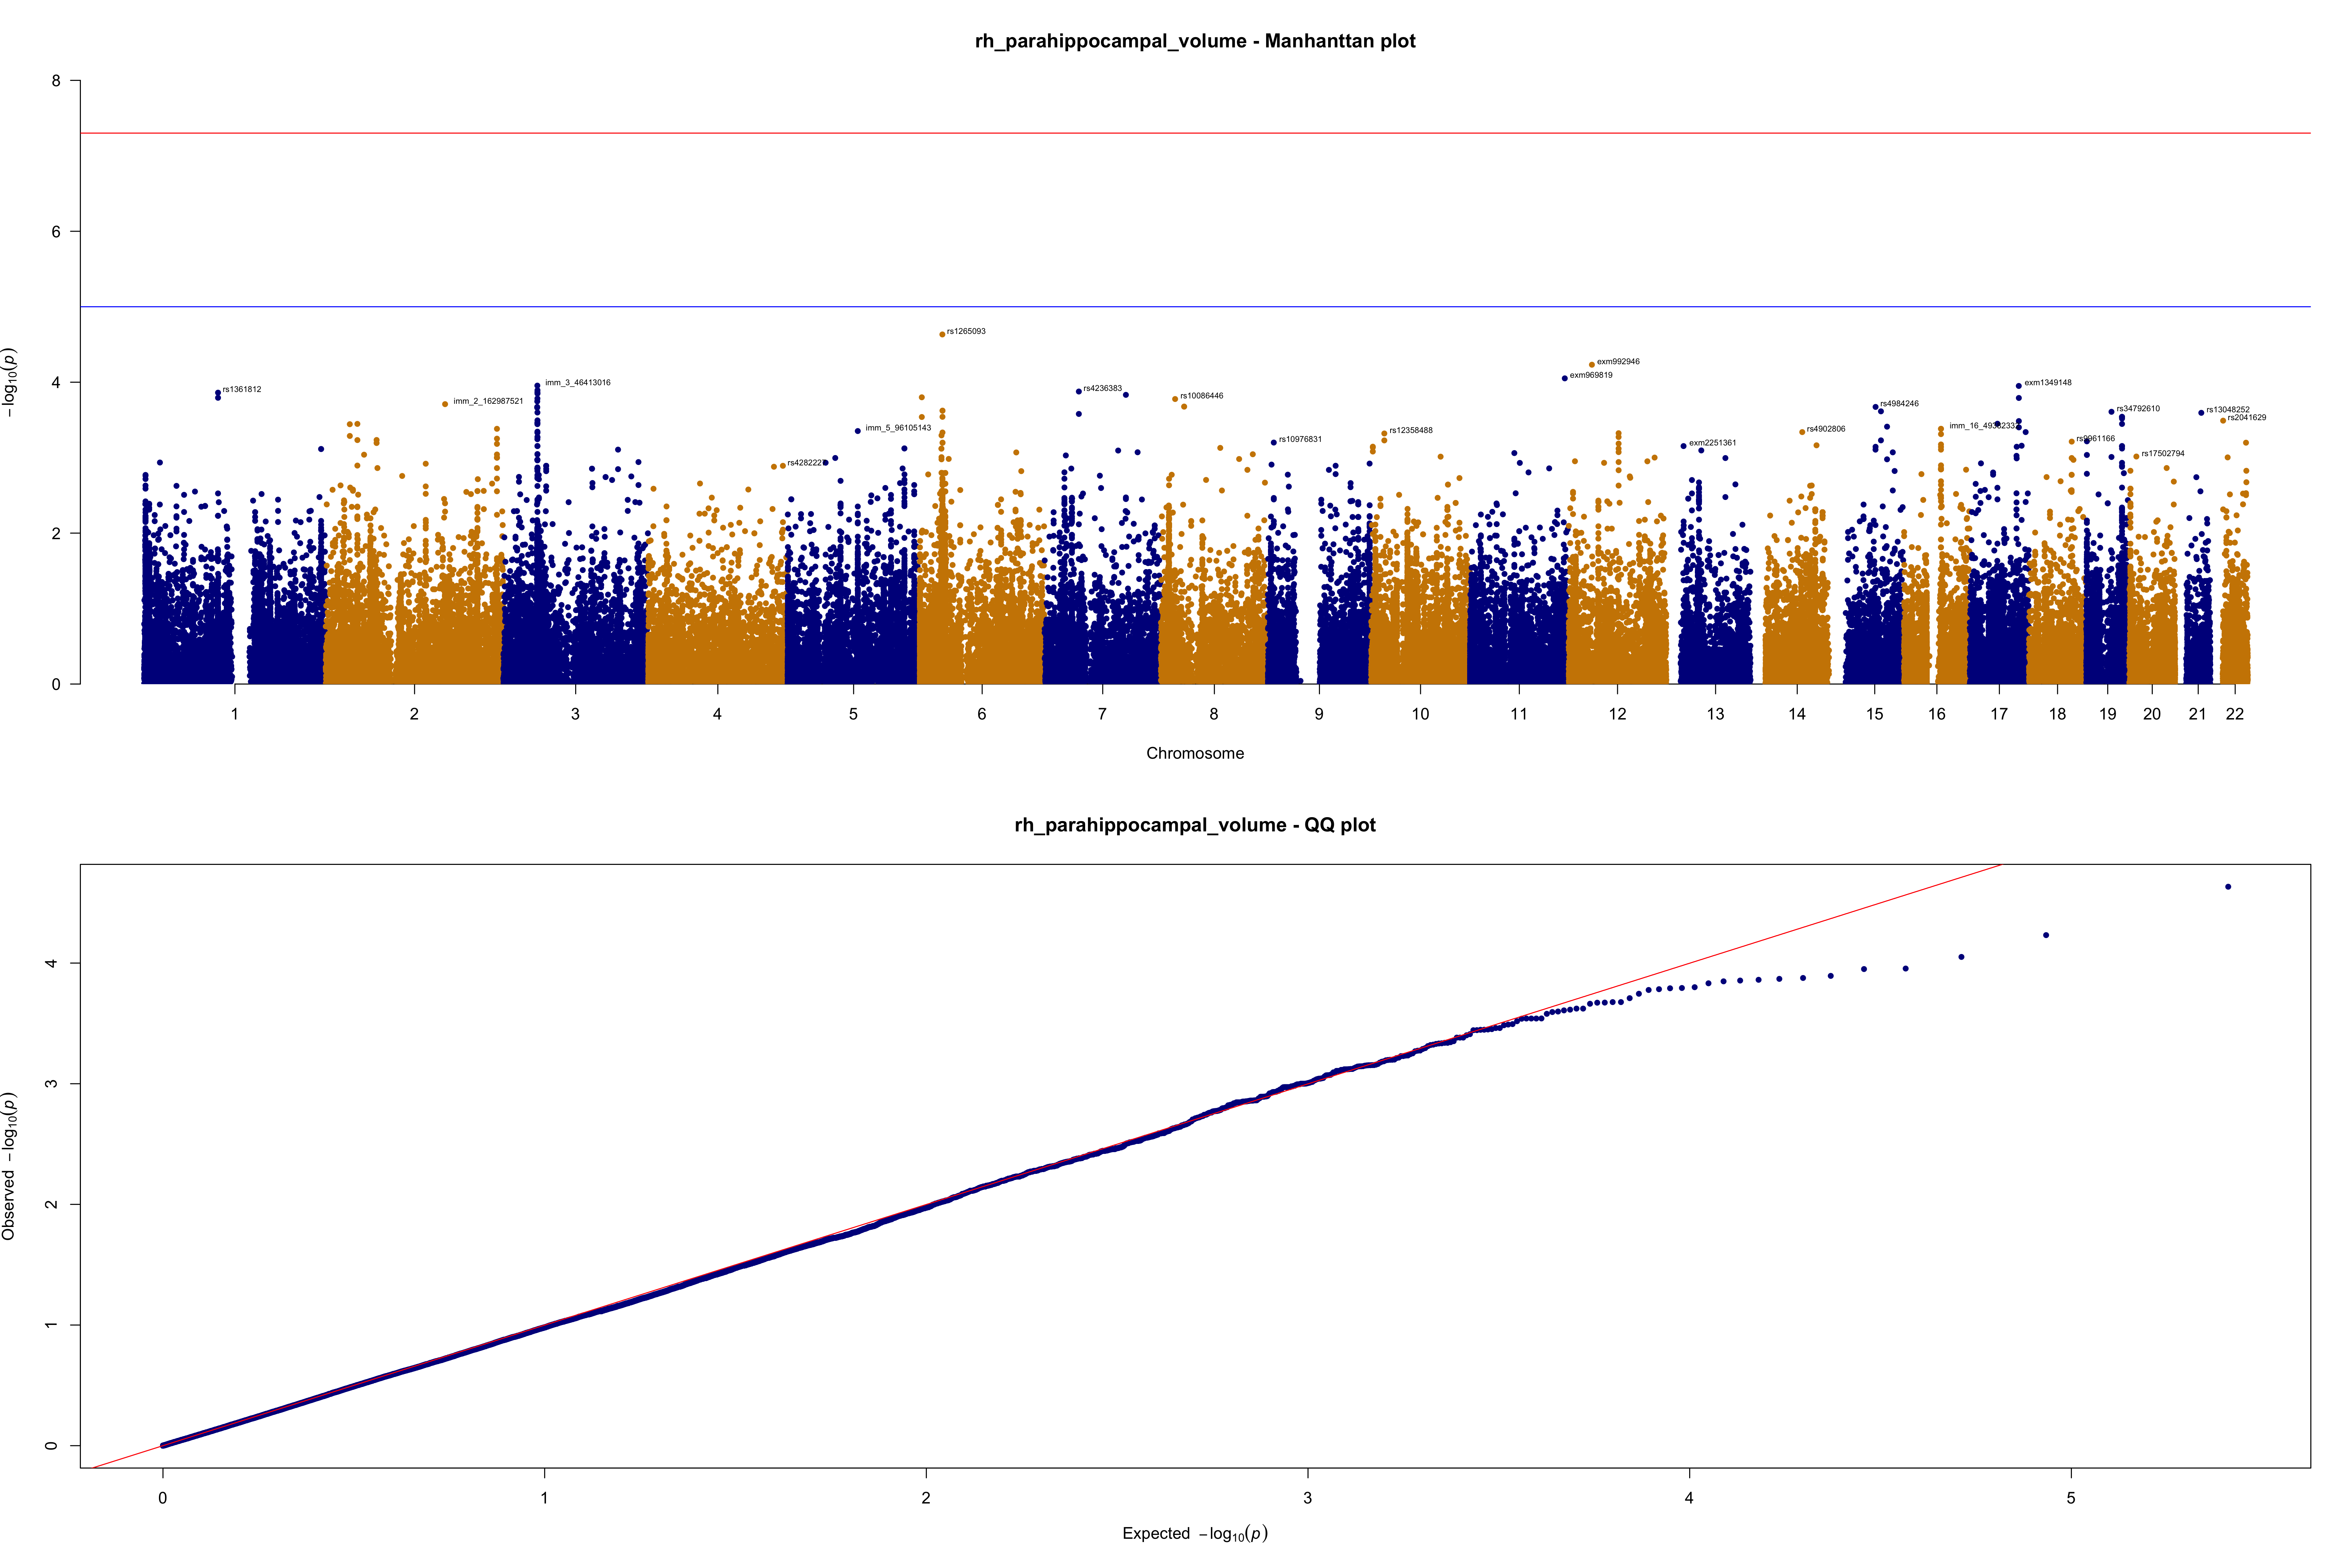

In [15]:
Image.open(os.path.join(indview_mri_res_path, "rh_parahippocampal_volume.png"))

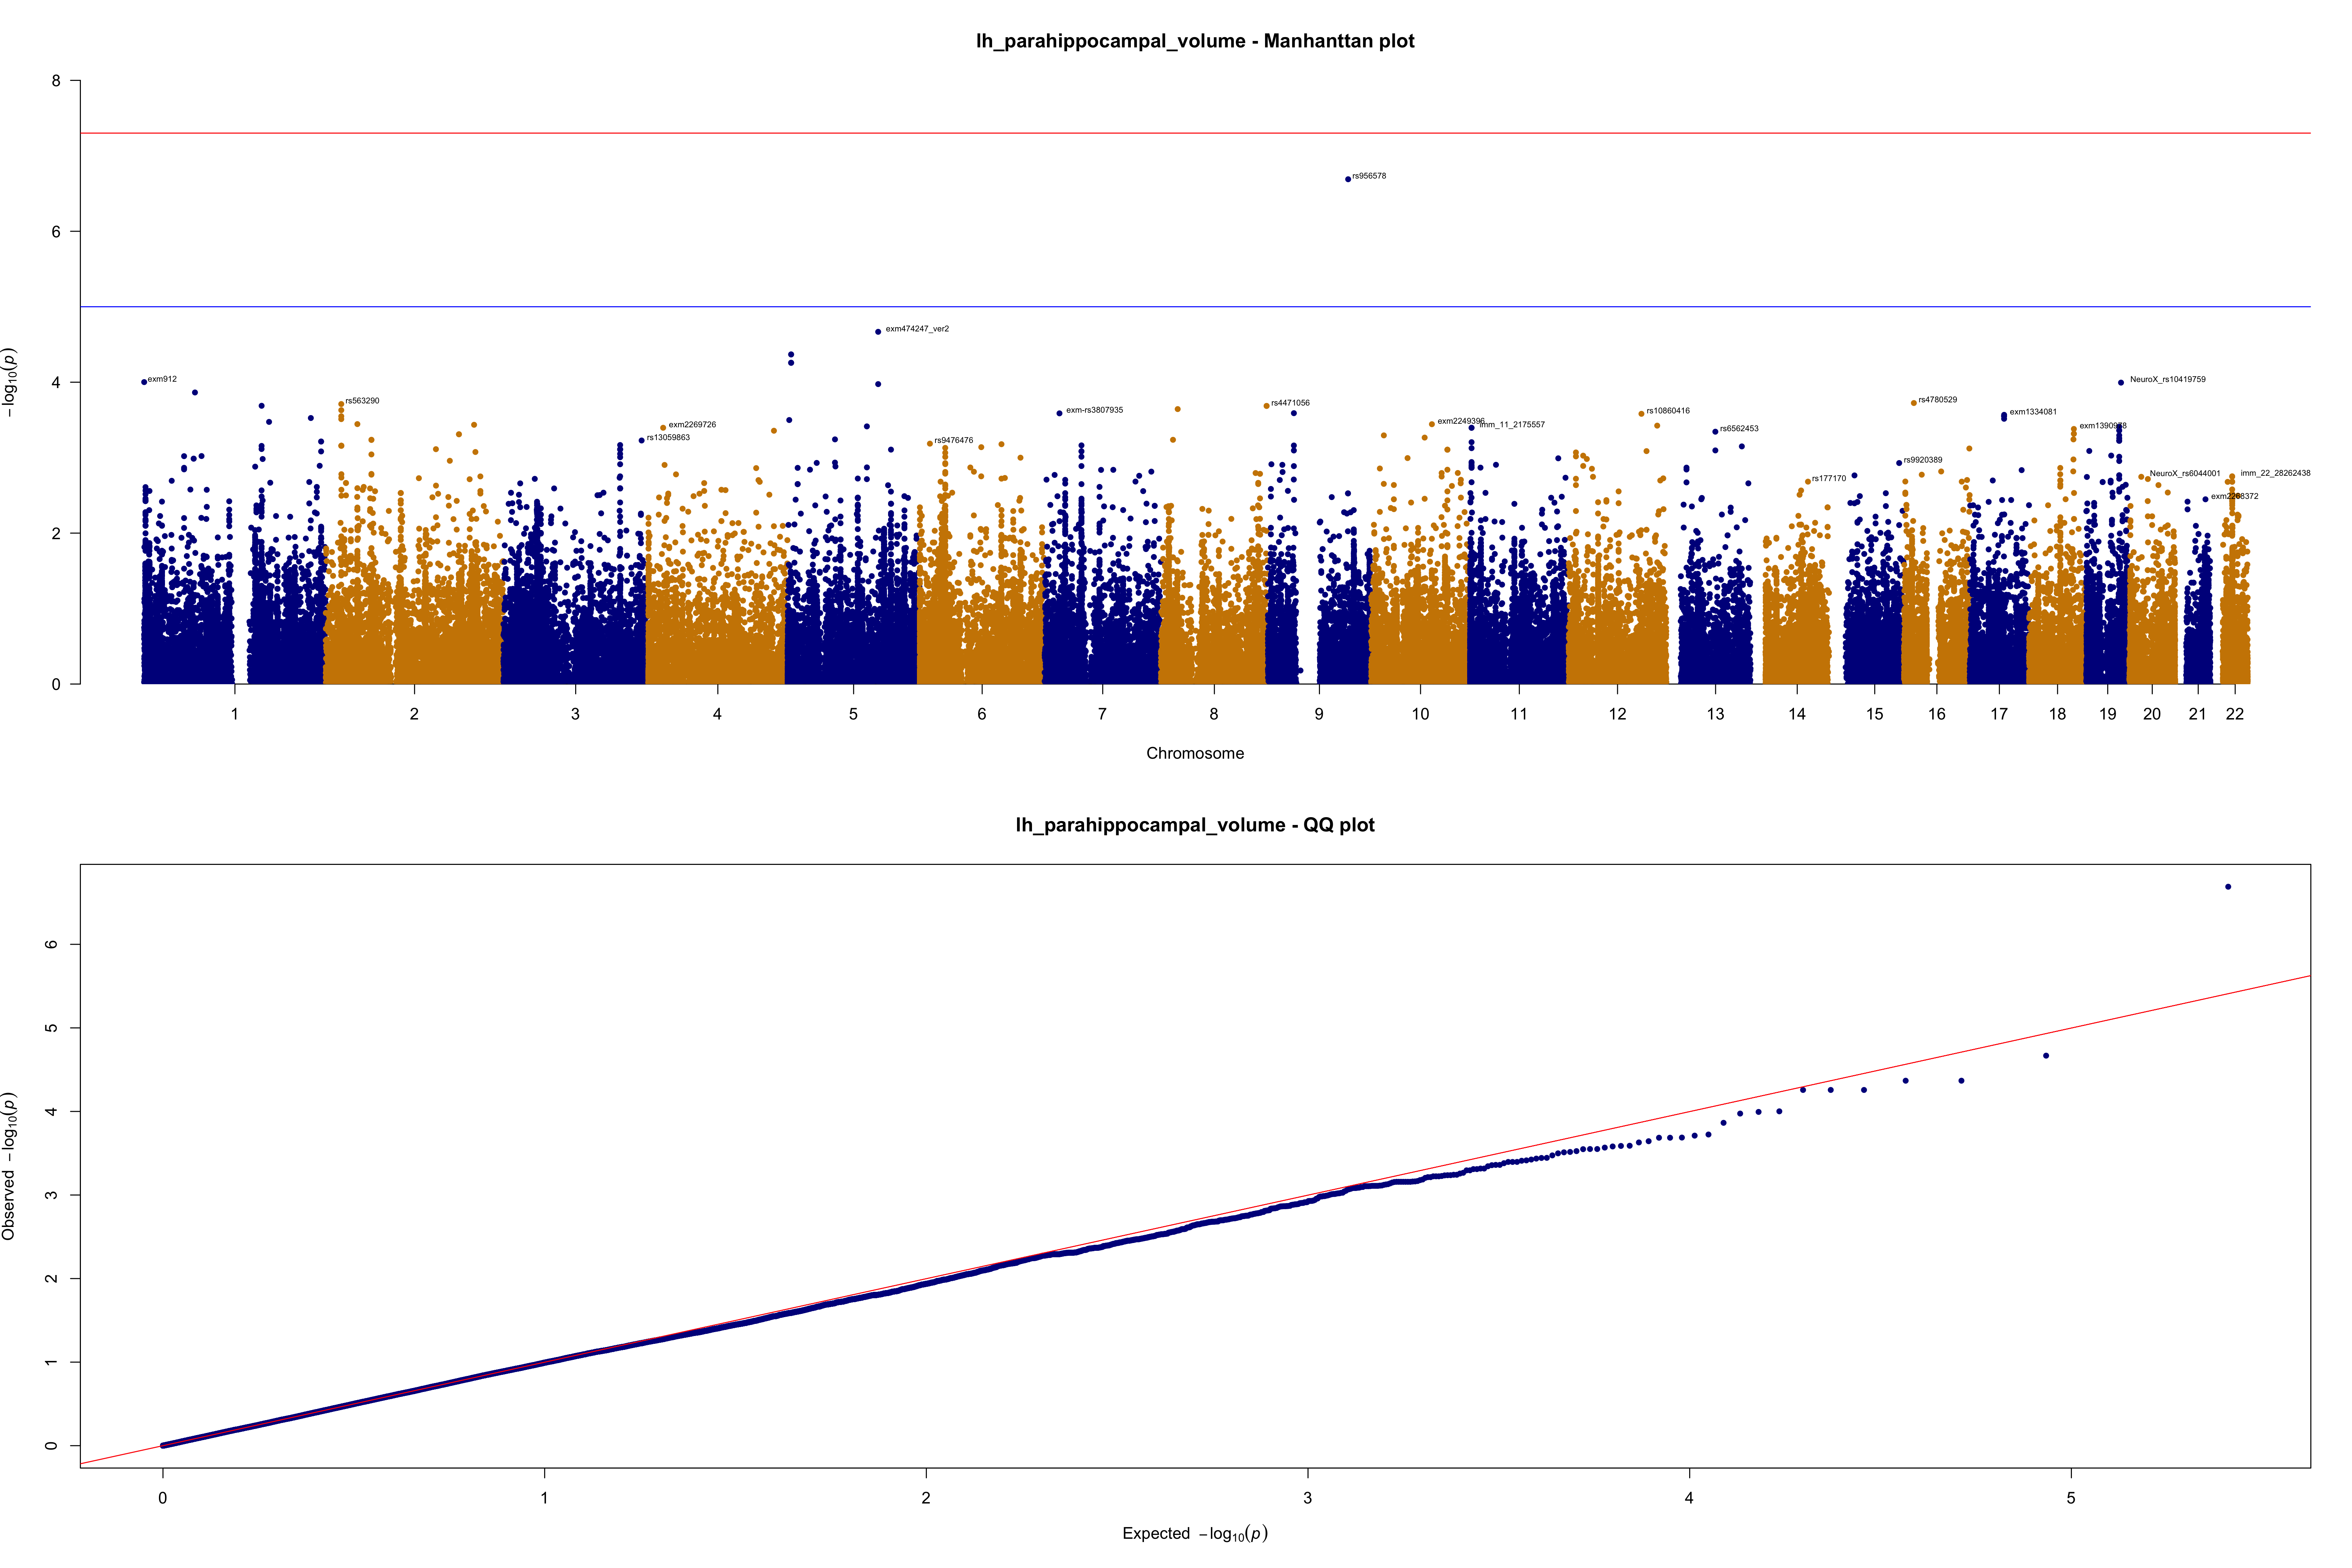

In [16]:
Image.open(os.path.join(indview_mri_res_path, "lh_parahippocampal_volume.png"))

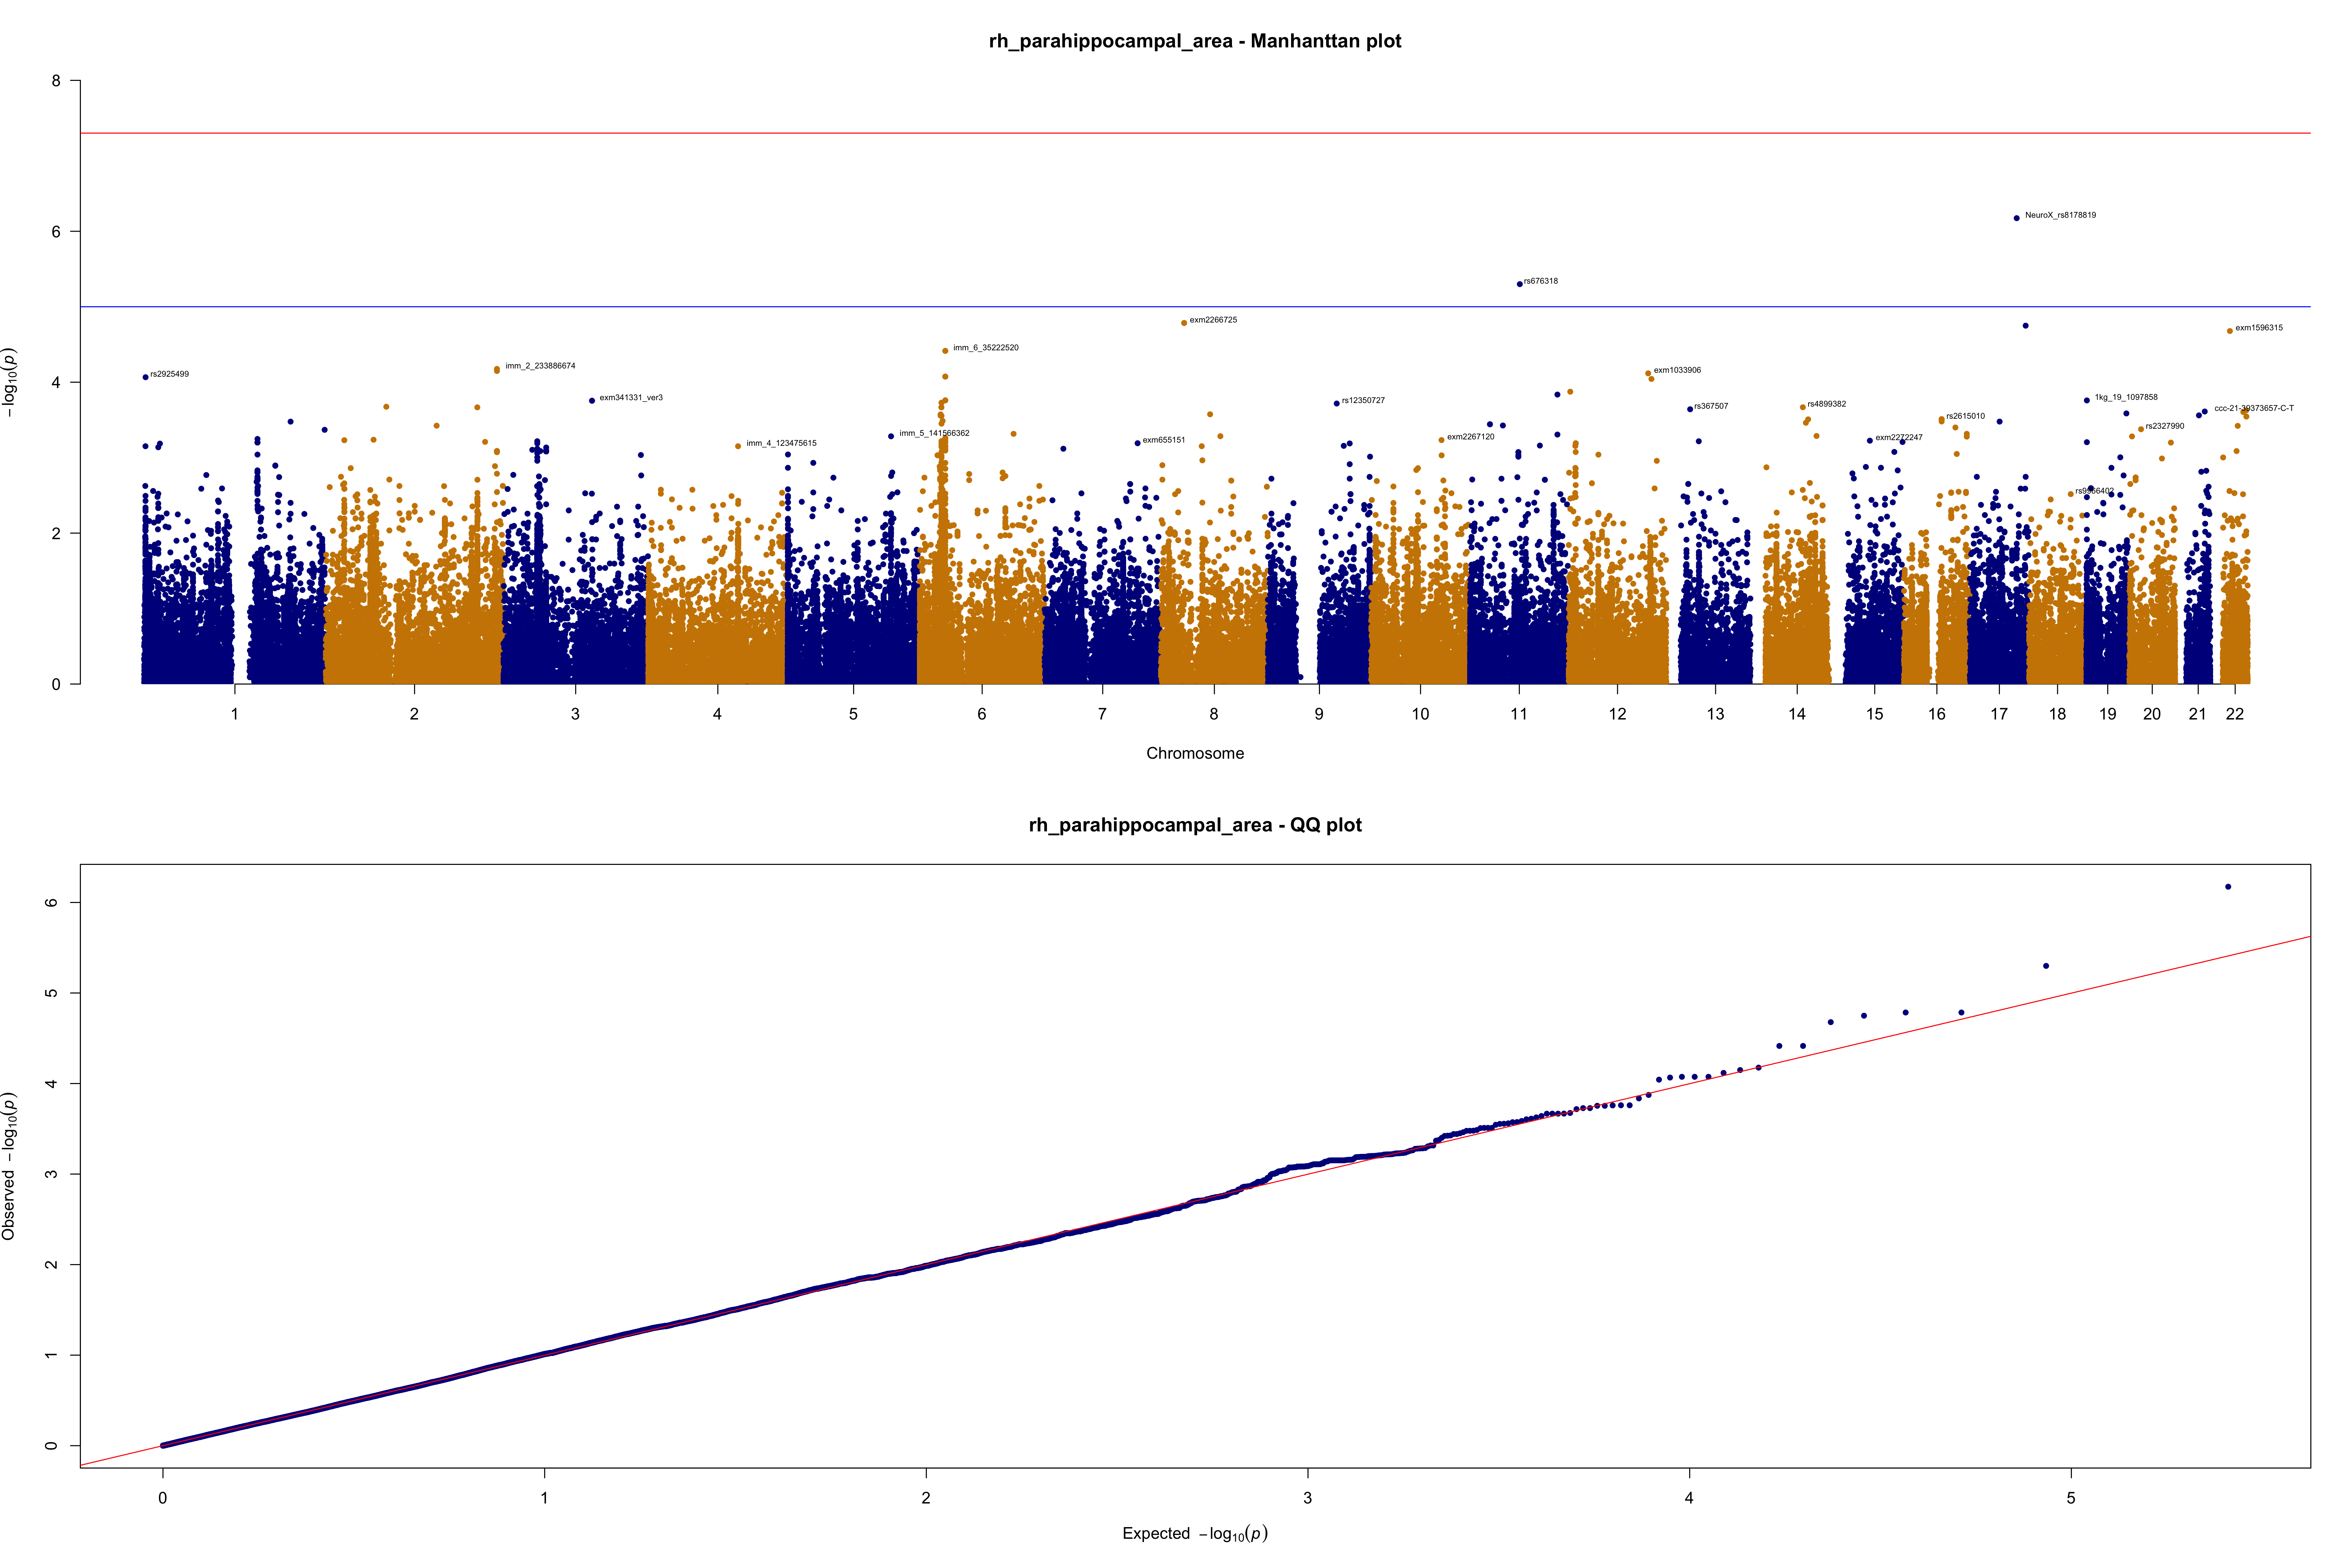

In [17]:
Image.open(os.path.join(indview_mri_res_path, "rh_parahippocampal_area.png"))

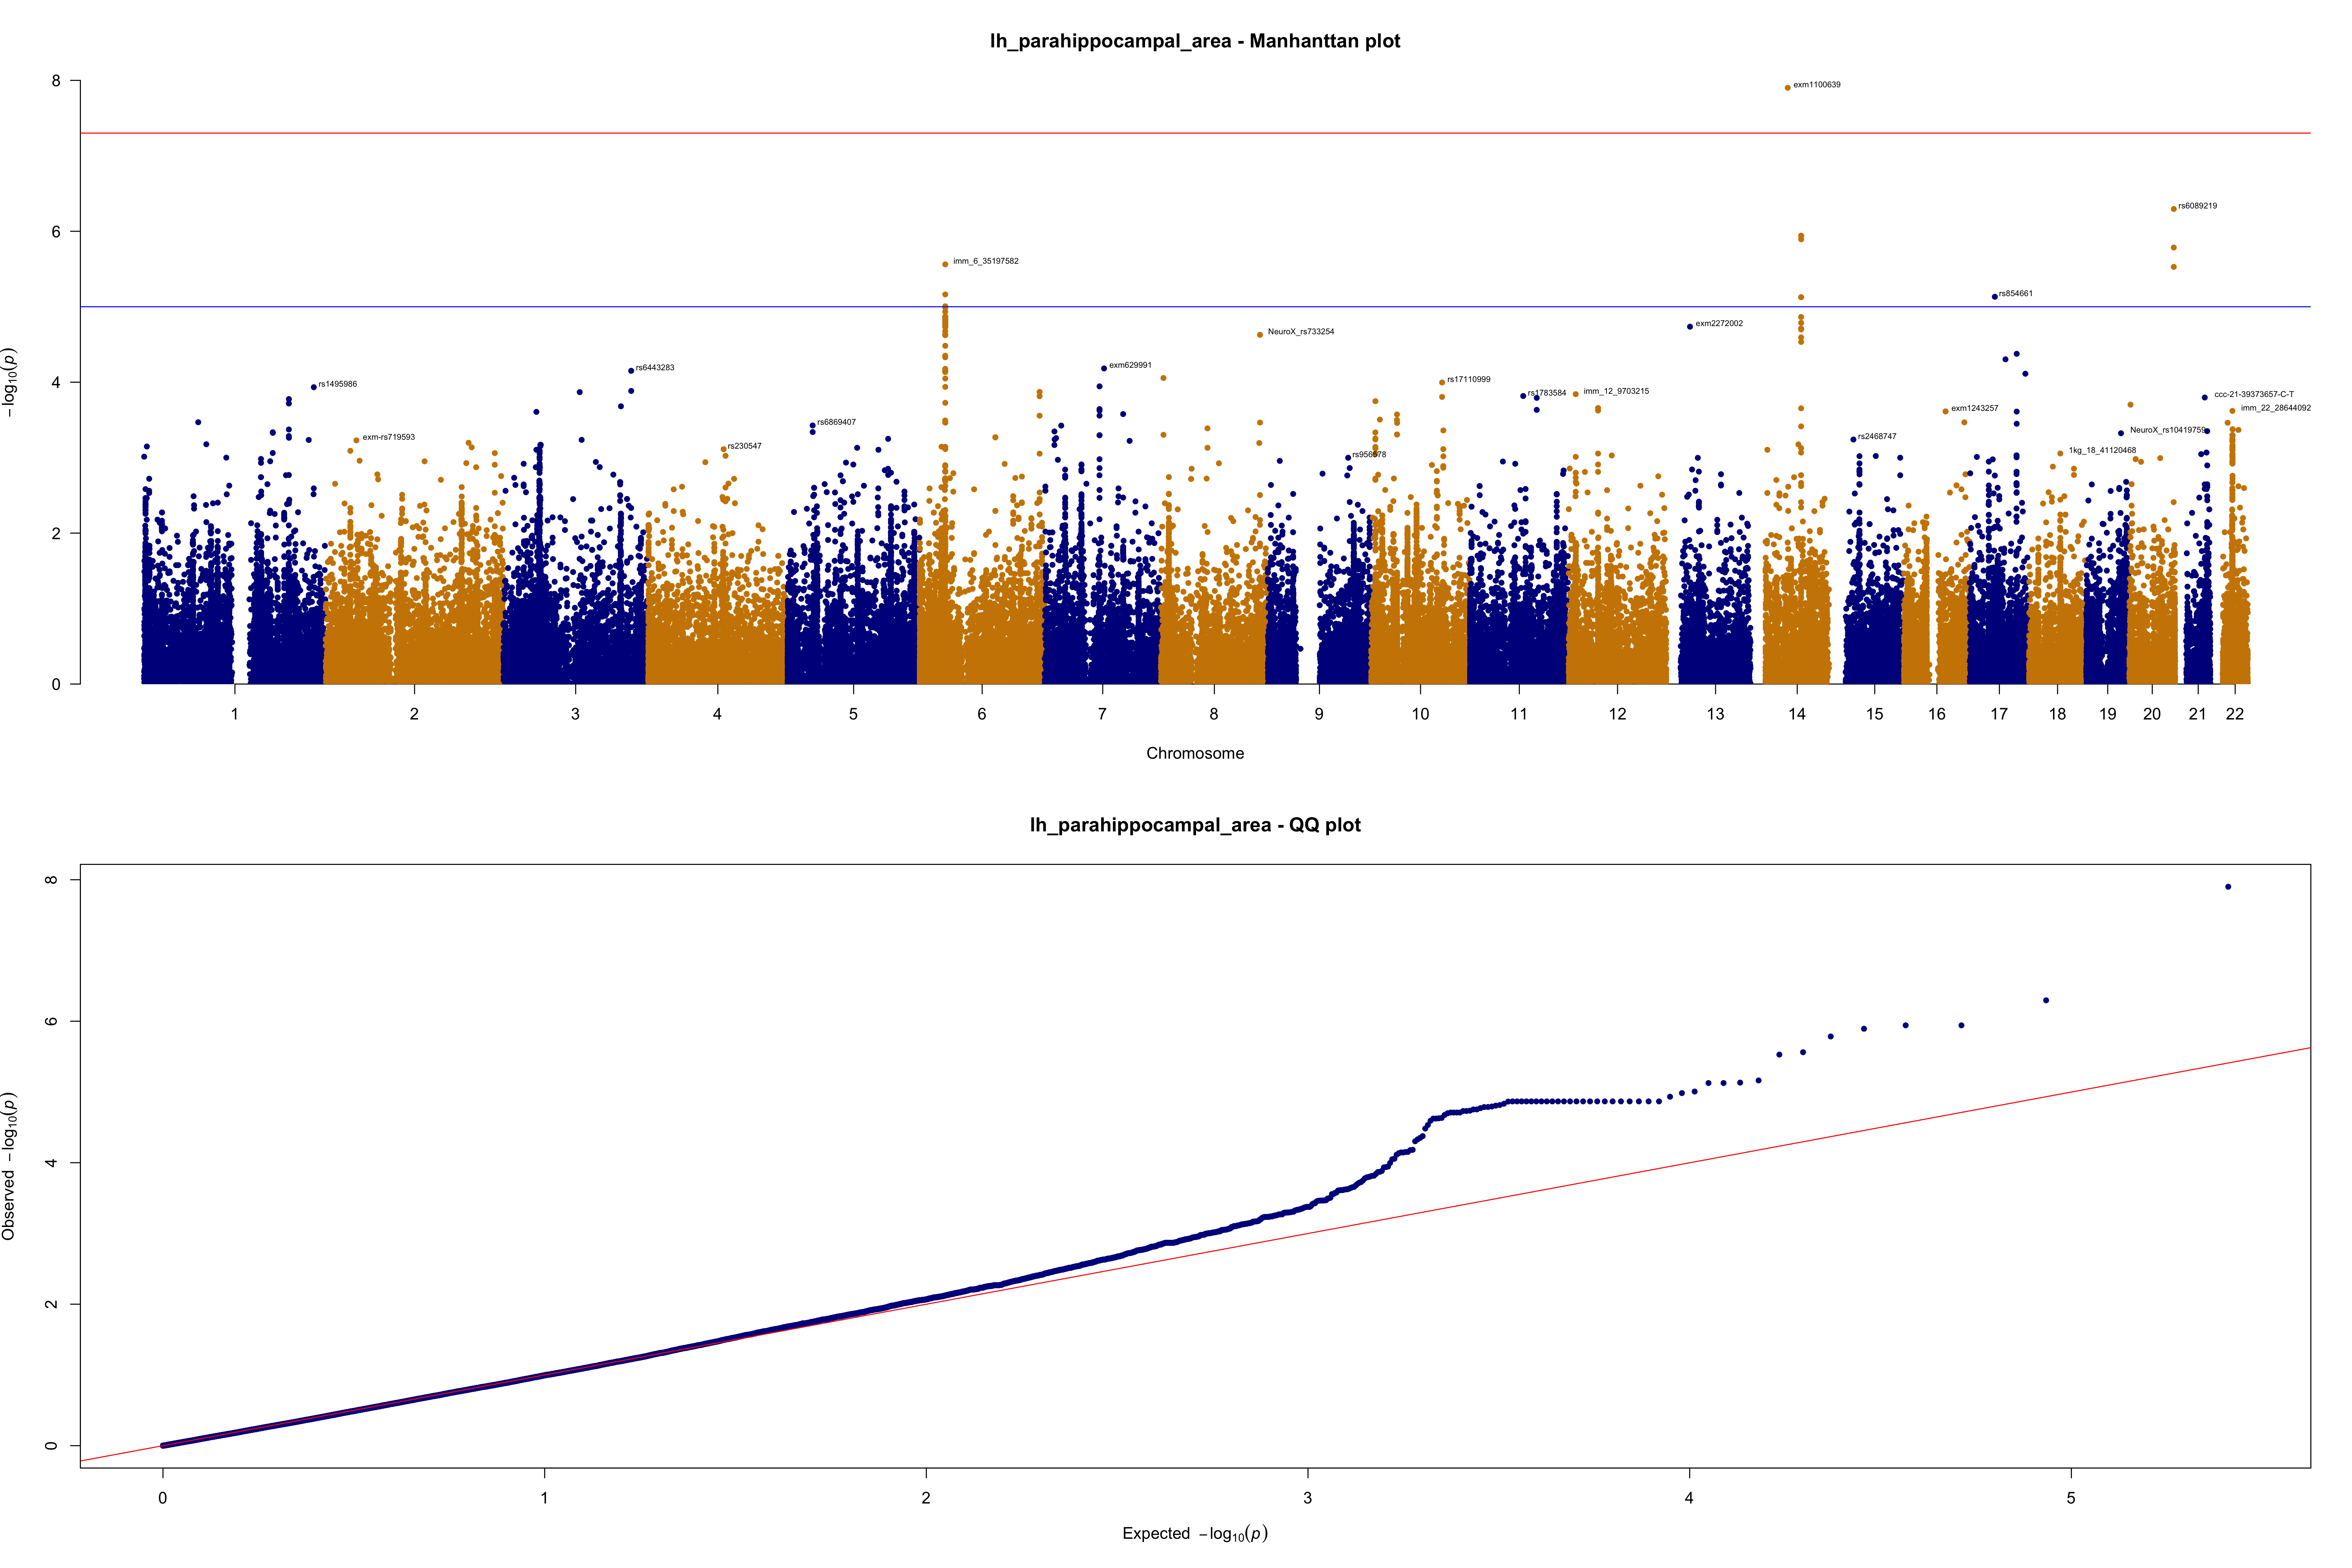

In [18]:
Image.open(os.path.join(indview_mri_res_path, "lh_parahippocampal_area.png"))

Surprisingly, we found several SNPs over the significance threshold (*P*-value $ < 1e^{-5}$).

| **Right parahippo volume** | **Left parahippo volume** | **Right parahippo area** | **Left parahippo area** |
| --- | --- | --- | --- |
| | rs956578 | rs676318 | imm_6_35154526 |
| | | NeuroX_rs8178819 | imm_6_35197300 |
| | | | imm_6_35197582 |
| | | | exm1100639|
| | | | imm_14_68294872 |
| | | | imm_14_68295774 |
| | | | imm_14_68347498 |
| | | | imm_14_68354031 |
| | | | imm_14_68357934 |
| | | | rs854661 |
| | | | exm1555934 |
| | | | exm1555949 |
| | | | rs6089219 |

To have a consistent summary of all these results we must combine them together. To combine the results obtained during the GWAS we use TATES, which combines the P-values in a single-trait-based statistical significance, by correcting for correlation among the imaging features, and evaluating if at least one of the analyzed traits could be associated with a SNP.

## Combining GWAS results in a single-trait based summary statistics

To combine the GWAS results we use TATES (Van der Sluis *et al.*, 2013), as we did with DaTSCAN uptake values. 

Let's begin by building the phenotype correlation matrix. 

In [19]:
tateswd = os.path.join(genotyping_path, "tates_mri_wd")
!mkdir -p {tateswd}

In [20]:
phenotype_vals = np.array(
    phenotype.replace(to_replace="NA", value=np.nan).iloc[:, [3,4,5,6]]
) # get only MRI measures
corr_mat = np.ma.corrcoef(np.ma.masked_invalid(phenotype_vals), rowvar=False)  # observations on rows and mask NAs
corr_mat = np.float32(np.array(corr_mat))
corr_mat

array([[1.        , 0.49166888, 0.6597612 , 0.32351092],
       [0.49166888, 1.        , 0.19700313, 0.58682096],
       [0.6597612 , 0.19700313, 1.        , 0.5375368 ],
       [0.32351092, 0.58682096, 0.5375368 , 1.        ]], dtype=float32)

In [21]:
corr_mat_fn = "corr_mat"
pd.DataFrame(corr_mat).to_csv(
    os.path.join(tateswd, corr_mat_fn),
    header=False,
    index=False,
    sep=" "
)

Let's construct the *P*-values file.

In [22]:
pvals_fn = "pvals"
pd.DataFrame(
    {
        0:parahippo_vol_r.iloc[:,0],  # chromosome
        1:parahippo_vol_r.iloc[:,1],  # SNP name
        2:parahippo_vol_r.iloc[:,8],  # right parahippo volume pvals
        3:parahippo_vol_l.iloc[:,8],  # left parahippo volume pvals
        4:parahippo_area_r.iloc[:,8], # right parahippo area pvals
        5:parahippo_area_l.iloc[:,8]  # left parahippo area pvals
    }
).to_csv(
   os.path.join(tateswd, pvals_fn),
    header=False,
    index=False,
    sep=" "
)

And let's build the ```defdims``` required by TATES to run.

In [23]:
pheno_num = 4
corr_mat_type = "full"  # full correlation matrix
snp_num = len(parahippo_vol_r.iloc[:,8].tolist())
tates_res_fn = "tates_mri_results"

towrite = "{0} {1}\n{2}\n{3}\n{4}\n{5}".format(
    pheno_num,  # number of phenotype
    snp_num,  # number of snps
    corr_mat_type,  # correlation matrix type
    pvals_fn,  # pvals file
    corr_mat_fn,  # correlation matrix file
    tates_res_fn
)

try:
    with open(os.path.join(tateswd, "defdims"), mode="w+") as outfile:
        outfile.write(towrite)
except Exception as e:
    raise e
finally:
    outfile.close()

Finally, we can run TATES to combine MRI data GWAS results in a single-trait based statistical significance assessment.

In [24]:
cwd = os.getcwd()
os.chdir(tateswd) # go to tates dir
!./tates 
os.chdir(cwd)  # go back to origin

  starting 
  EVD of phenotypes finished 
  snp 1 to snps (every 10000 shown)
  SNP        10000      128812
  SNP        20000      128812
  SNP        30000      128812
  SNP        40000      128812
  SNP        50000      128812
  SNP        60000      128812
  SNP        70000      128812
  SNP        80000      128812
  SNP        90000      128812
  SNP       100000      128812
  SNP       110000      128812
  SNP       120000      128812
STOP end tates 


Now we can plot the new resulting manhattan and QQ plots.

In [25]:
!Rscript plot_tates_mri.R

Loading required package: qqman

For example usage please run: vignette('qqman')

Citation appreciated but not required:
Turner, S.D. qqman: an R package for visualizing GWAS results using Q-Q and manhattan plots. biorXiv DOI: 10.1101/005165 (2014).

null device 
          1 


After the single-trait based correction performed by TATES, we still have eight SNPs with *P*-value over the suggestive value of $1e^{-5}$:

- imm_6_35197582

- rs956578

- exm1100639

- imm_14_68347498

- imm_14_68354031

- imm_14_68357934

- NeuroX_rs8178819

- exm1555934

- rs6089219

In [26]:
tates_res = pd.read_csv(
    os.path.join(tateswd, tates_res_fn),
    header=None,
    sep="\s+"
)
tates_res[tates_res[3] < 1e-5].iloc[:,1].tolist() # get SNPs with P-value < 1e-5

['imm_6_35197582',
 'rs956578',
 'exm1100639',
 'imm_14_68347498',
 'imm_14_68354031',
 'imm_14_68357934',
 'NeuroX_rs8178819',
 'exm1555934',
 'rs6089219']

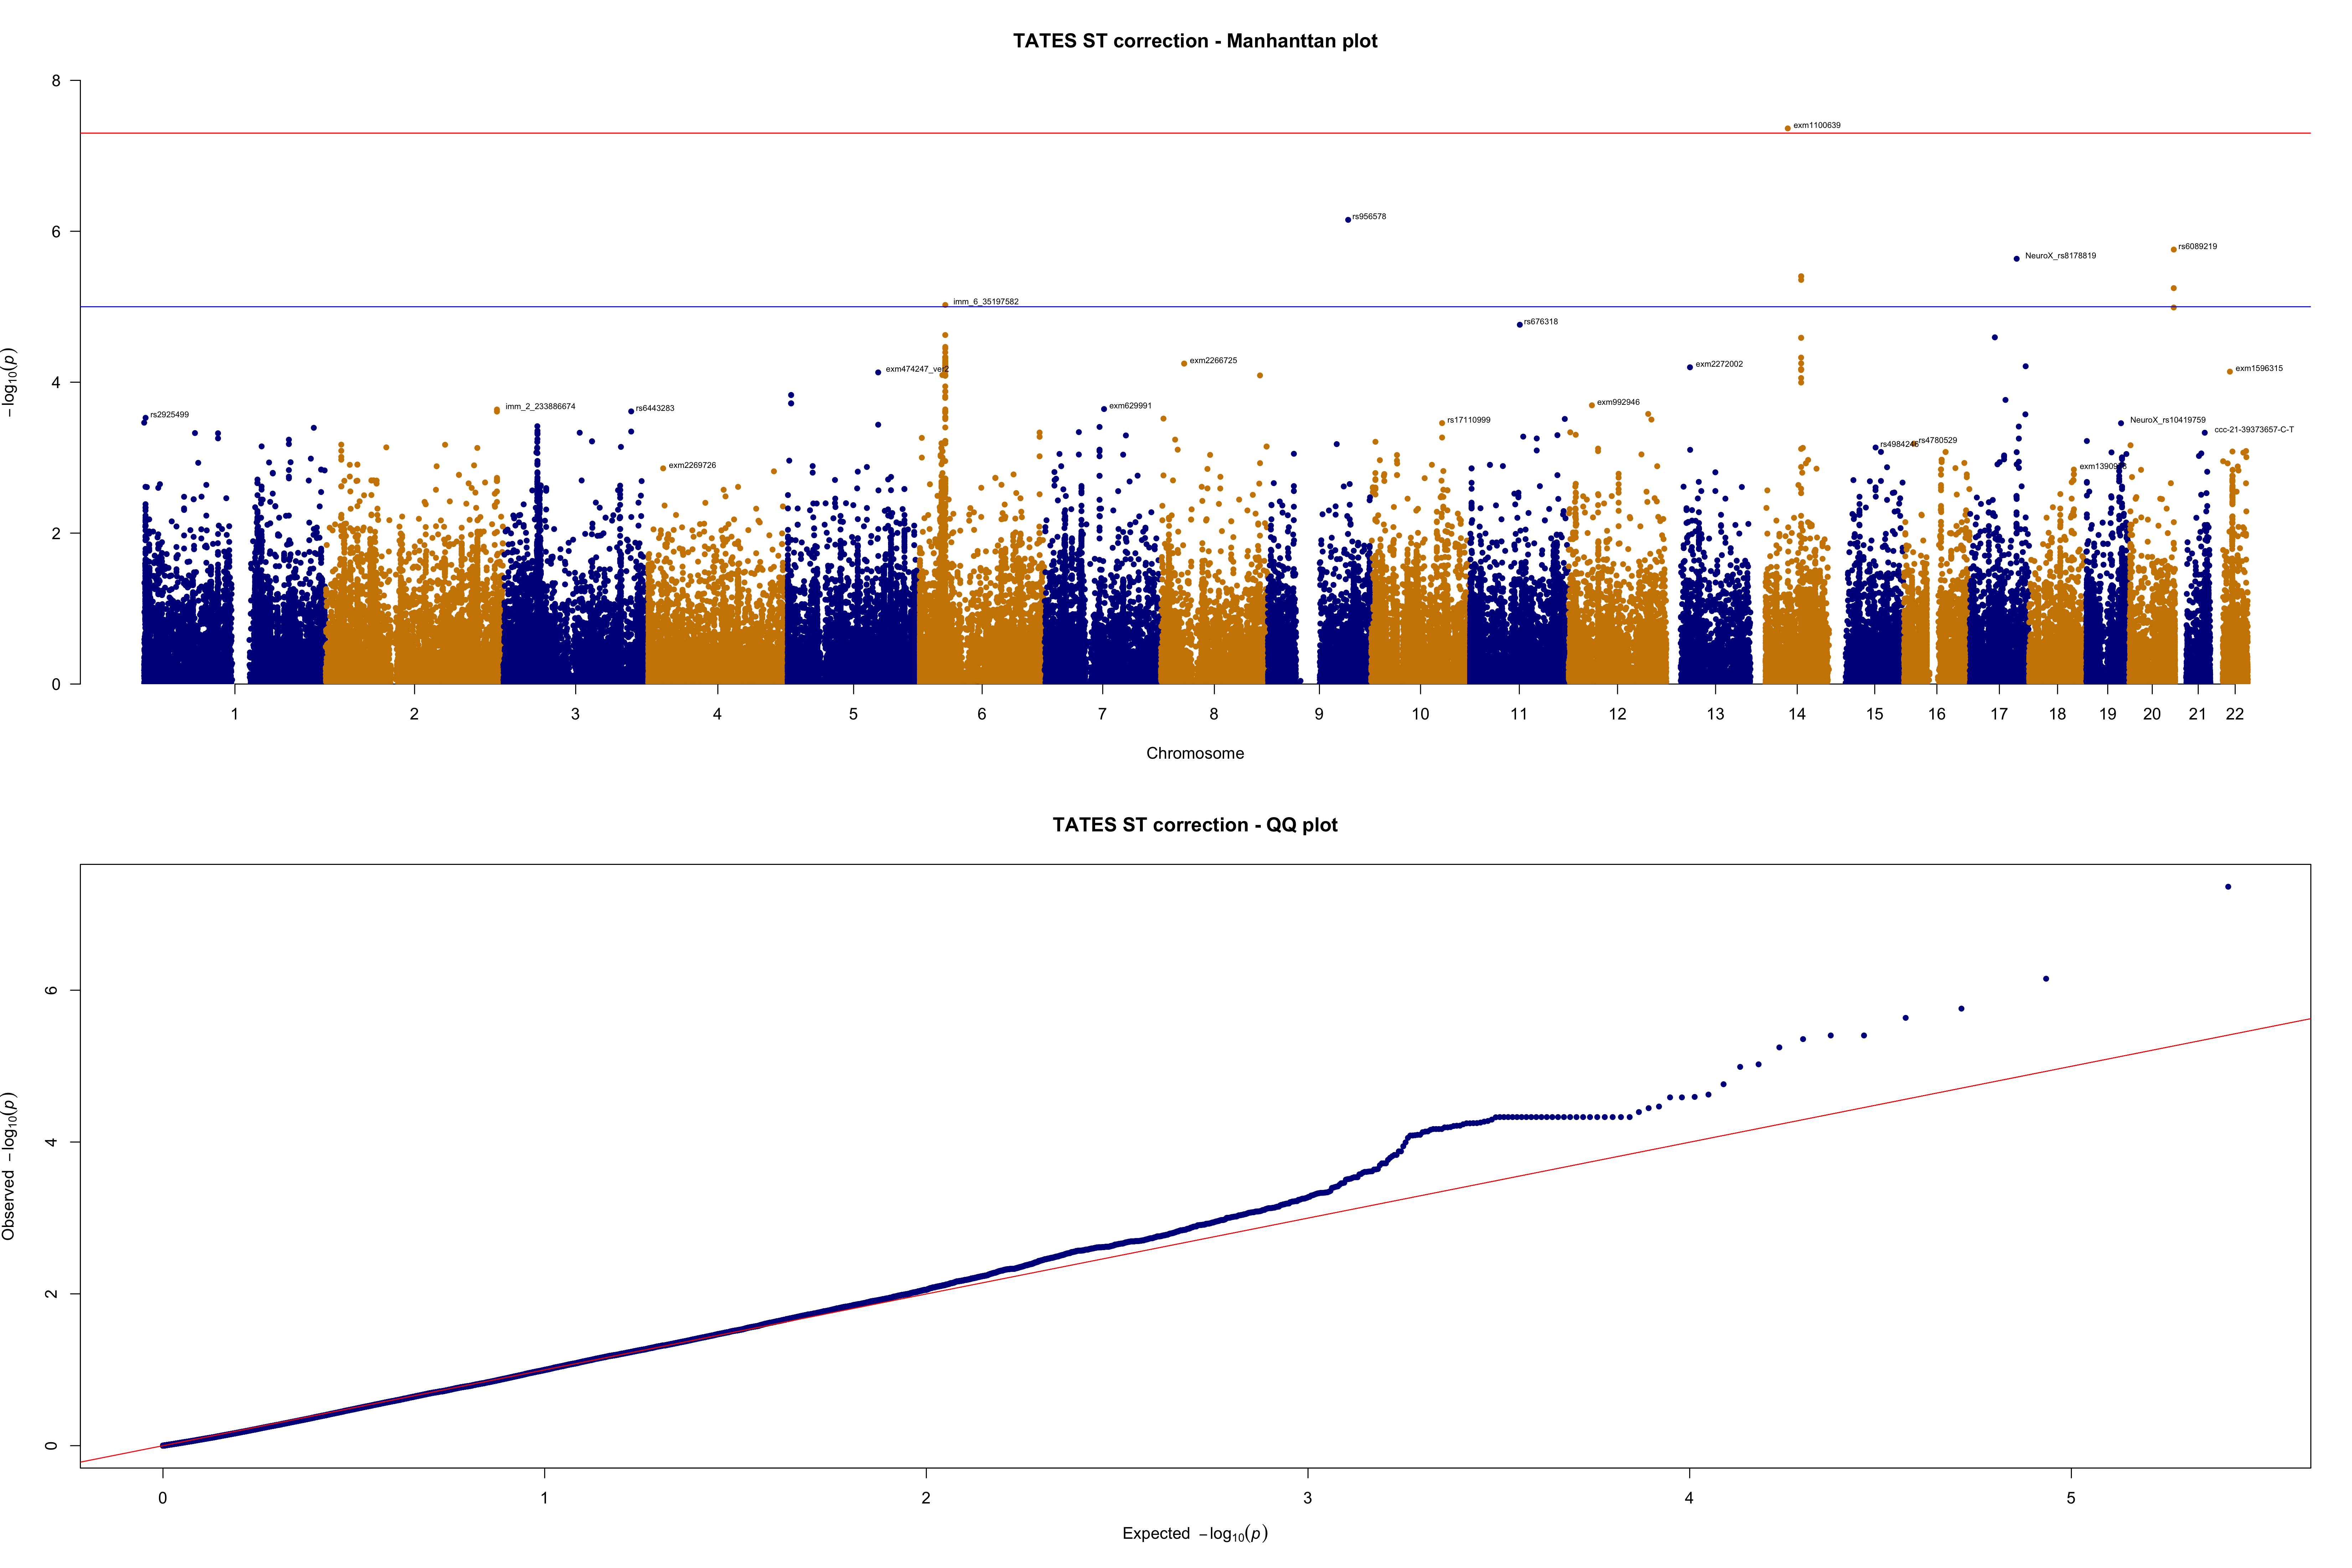

In [27]:
Image.open(os.path.join(indview_mri_res_path, "tates_st_correction.png"))